In [1]:
import logging
import pickle
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [2]:
df_raw = sns.load_dataset("flights")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [3]:
df_raw.sample(10, random_state=2025)

,year,month,passengers
2,1949,Mar,132
82,1955,Nov,237
77,1955,Jun,315
26,1951,Mar,178
23,1950,Dec,140
44,1952,Sep,209
54,1953,Jul,264
0,1949,Jan,112
5,1949,Jun,135
108,1958,Jan,340


In [4]:
df_baking = df_raw.copy()
df_baking['month'] = pd.to_datetime(df_baking['month'], format='%b').dt.month
df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day=1))
df_baking = df_baking.set_index('date')
df_baking = df_baking.drop(columns=['year','month'])
df = df_baking.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [5]:
df_train = df.iloc[:-12,:]
df_test = df.iloc[-12,:]
df_train.sample(10, random_state=2025)

,passengers
date,
1953-01-01,196
1950-08-01,170
1954-04-01,227
1954-07-01,302
1958-06-01,435
1952-02-01,180
1959-10-01,407
1951-06-01,178
1953-11-01,180


In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
passengers,132.0,262.492424,106.625799,104.0,176.5,239.5,343.25,559.0


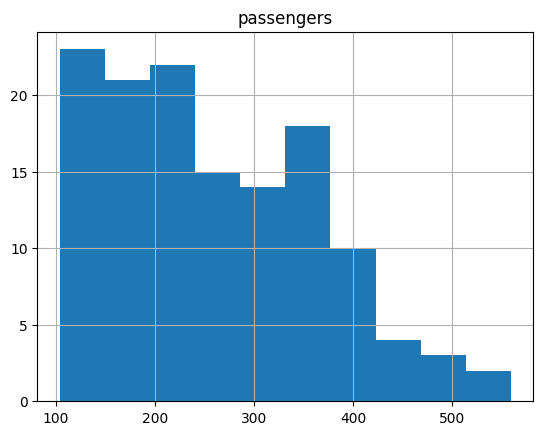

In [7]:
df_train.hist()
plt.show()

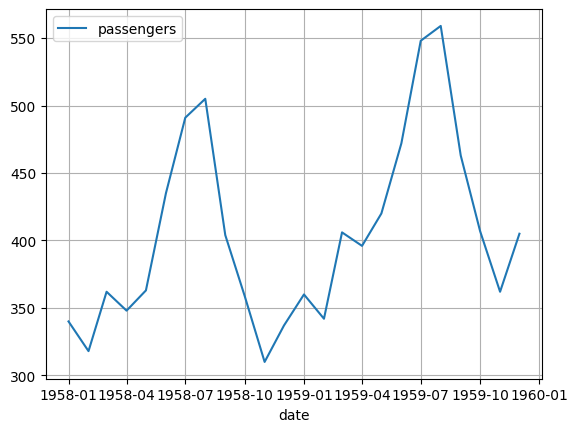

In [8]:
sns.lineplot(df_train.iloc[-24:,:])
plt.grid(True)
plt.show()

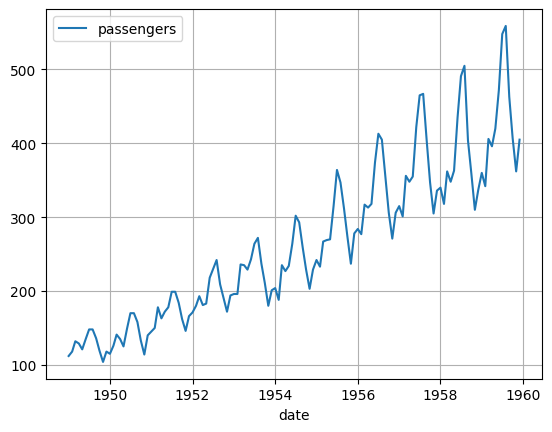

In [9]:
sns.lineplot(df_train)
plt.grid(True)
plt.show()

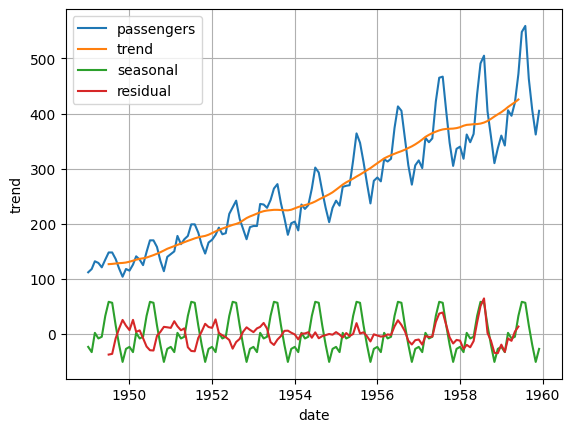

In [10]:
decomposition = seasonal_decompose(df_train['passengers'], period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(df_train)
sns.lineplot(trend, label='trend')
sns.lineplot(seasonal, label='seasonal')
sns.lineplot(residual,label='residual')
plt.grid(True)
plt.show()

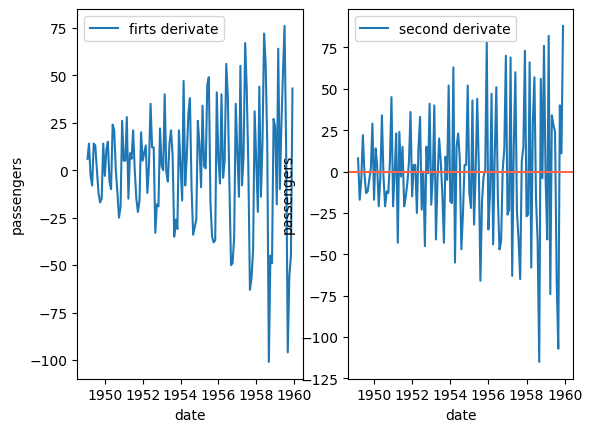

In [11]:
#d = stationarity
fig, ax = plt.subplots(1,2)
sns.lineplot(df_train['passengers'].diff(), label='firts derivate', ax=ax[0])
sns.lineplot(df_train['passengers'].diff().diff(), label= 'second derivate', ax=ax[1])
plt.axhline(0,color='tomato')
plt.show()

In [12]:
# if p value menor que alpha entonces no es estacionario
ad_fuller = adfuller(df_train)
print(f'adf statisti: {ad_fuller[0]:.2f}')
print(f'adf p_value: {ad_fuller[1]:.2f}')

adf statisti: 0.89
adf p_value: 0.99


In [13]:
# if p value menor que alpha entonces no es estacionario
ad_fuller = adfuller(df_train['passengers'].diff().dropna())
print(f'adf statisti: {ad_fuller[0]:.2f}')
print(f'adf p_value: {ad_fuller[1]:.2f}')

adf statisti: -2.40
adf p_value: 0.14


In [15]:
# if p value menor que alpha entonces no es estacionario
ad_fuller = adfuller(df_train['passengers'].diff().diff().dropna())
print(f'adf statisti: {ad_fuller[0]:.2f}')
print(f'adf p_value: {ad_fuller[1]:.2f}')

adf statisti: -14.25
adf p_value: 0.00


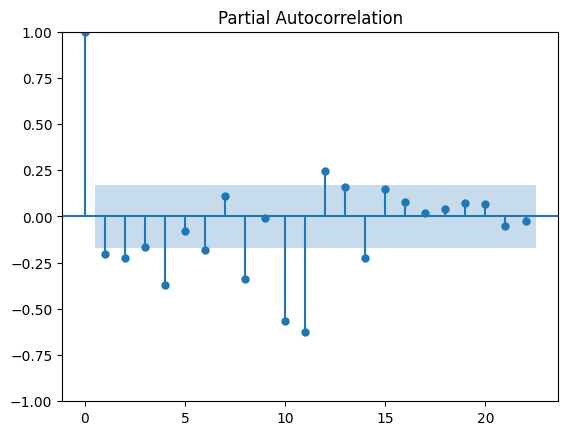

In [16]:
plot_pacf(df_train.diff().diff().dropna())
plt.show()

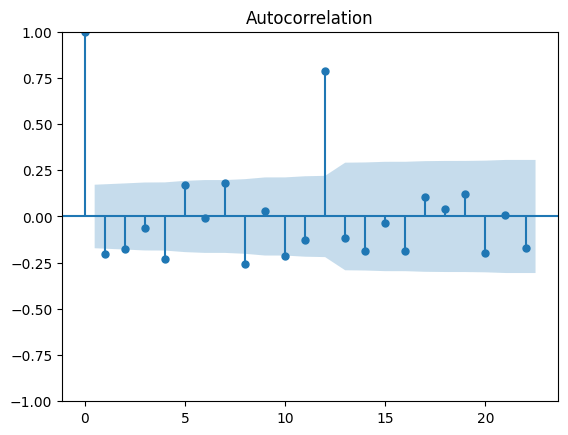

In [23]:
plot_acf(df_train.diff().diff().dropna())
plt.show()

In [22]:
arima = ARIMA(df['passengers'], order=(2,1,1)) # d, derivadas, p partial autocorrelacion, q average
ts_arima = arima.fit()
print(ts_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Thu, 06 Mar 2025   AIC                           1378.338
Time:                        03:35:40   BIC                           1390.190
Sample:                    01-01-1949   HQIC                          1383.154
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.0

/workspaces/4geeks_class/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


se debe tratar de llegar a que el p value sea lo mas chico posible, y el AIC entre mas chiquito mejor

In [24]:
y_hat = ts_arima.predict(12)
y_hat

1950-01-01    128.792484
1950-02-01    116.472209
1950-03-01    131.447933
1950-04-01    143.937152
1950-05-01    128.651503
                 ...    
1960-08-01    614.637225
1960-09-01    553.295210
1960-10-01    447.163379
1960-11-01    445.985159
1960-12-01    382.790890
Freq: MS, Name: predicted_mean, Length: 132, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

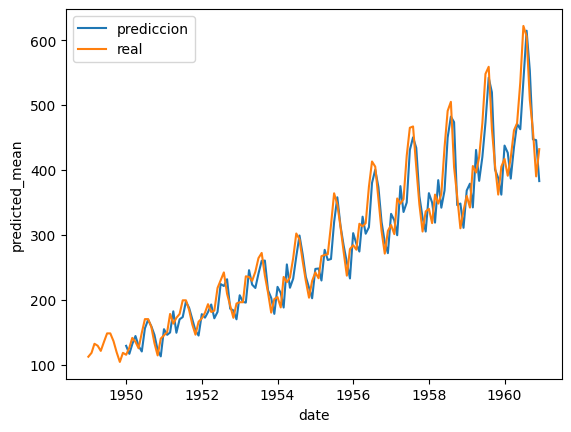

In [25]:
sns.lineplot(y_hat, label='prediccion')
sns.lineplot(df['passengers'], label='real')
plt.show